In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')

## Reducing transaction types

We know that fraud is only in TRANSFER and CASH_OUT columns. So we'll focus our attention on only these columns for the modeling.

In [3]:
df_containing_fraud = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]

In [4]:
df_containing_fraud

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


## Reducing columns

We know that the columns of interest are ['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', oldBalanceDest', 'newbalanceDest', 'isFraud']
- isFlaggedFraud proved to be an erroneous column
- I could not figure out a way to analyze nameOrig & nameDest columns in a meaningful way ***could potentially be dropping significant columns**
- Was considering dropping step, but there is a slight pattern that we found across fraudulent transactions and time

In [5]:
new_df = df_containing_fraud.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1)

In [6]:
new_df

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.00,51513.44,0
19,1,TRANSFER,215310.30,705.00,0.0,22425.00,0.00,0
24,1,TRANSFER,311685.89,10835.00,0.0,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1


## Feature Engineering

Going to create columns that capture the relationships that I've uncovered in 01eda.ipynb

In [7]:
new_df['amount_equals_oldbalance'] = (new_df['amount'] == new_df['oldbalanceOrg']).astype(int)
new_df['oldbalance_equals_newbalance'] = (new_df['oldbalanceDest'] == new_df['newbalanceDest']).astype(int)

new_df


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,amount_equals_oldbalance,oldbalance_equals_newbalance
2,1,TRANSFER,181.00,181.00,0.0,0.00,0.00,1,1,1
3,1,CASH_OUT,181.00,181.00,0.0,21182.00,0.00,1,1,0
15,1,CASH_OUT,229133.94,15325.00,0.0,5083.00,51513.44,0,0,0
19,1,TRANSFER,215310.30,705.00,0.0,22425.00,0.00,0,0,0
24,1,TRANSFER,311685.89,10835.00,0.0,6267.00,2719172.89,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,339682.13,0.0,0.00,339682.13,1,1,0
6362616,743,TRANSFER,6311409.28,6311409.28,0.0,0.00,0.00,1,1,1
6362617,743,CASH_OUT,6311409.28,6311409.28,0.0,68488.84,6379898.11,1,1,0
6362618,743,TRANSFER,850002.52,850002.52,0.0,0.00,0.00,1,1,1


## Scaling

In [8]:
columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
standard_scaler = StandardScaler()

# originally tried scaling the columns of interest 
# but the scaled version of the dataframes were missing the 'isFraud' and new features columns
# this code fixes that problem

new_df_scaled = new_df.copy()  
new_df_scaled[columns_to_scale] = standard_scaler.fit_transform(new_df[columns_to_scale])


In [9]:
new_df_scaled

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,amount_equals_oldbalance,oldbalance_equals_newbalance
2,1,TRANSFER,-0.357467,-0.188847,-0.106389,-0.403155,-0.438259,1,1,1
3,1,CASH_OUT,-0.357467,-0.188847,-0.106389,-0.398142,-0.438259,1,1,0
15,1,CASH_OUT,-0.099576,-0.128591,-0.106389,-0.401952,-0.427245,0,0,0
19,1,TRANSFER,-0.115146,-0.186762,-0.106389,-0.397848,-0.438259,0,0,0
24,1,TRANSFER,-0.006590,-0.146456,-0.106389,-0.401672,0.143134,0,0,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,0.024945,1.161997,-0.106389,-0.403155,-0.365631,1,1,0
6362616,743,TRANSFER,6.751458,24.922965,-0.106389,-0.403155,-0.438259,1,1,1
6362617,743,CASH_OUT,6.751458,24.922965,-0.106389,-0.386947,0.925844,1,1,0
6362618,743,TRANSFER,0.599766,3.192516,-0.106389,-0.403155,-0.438259,1,1,1


## Dummy variables

In [10]:
df_bool = pd.get_dummies(new_df_scaled, columns=['type'], drop_first=True)

In [11]:
df_encoded = df_bool['type_TRANSFER'].astype(int)

In [12]:
df_bool['type_TRANSFER'] = df_encoded

In [13]:
df_fully_encoded = df_bool
df_fully_encoded

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,amount_equals_oldbalance,oldbalance_equals_newbalance,type_TRANSFER
2,1,-0.357467,-0.188847,-0.106389,-0.403155,-0.438259,1,1,1,1
3,1,-0.357467,-0.188847,-0.106389,-0.398142,-0.438259,1,1,0,0
15,1,-0.099576,-0.128591,-0.106389,-0.401952,-0.427245,0,0,0,0
19,1,-0.115146,-0.186762,-0.106389,-0.397848,-0.438259,0,0,0,1
24,1,-0.006590,-0.146456,-0.106389,-0.401672,0.143134,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6362615,743,0.024945,1.161997,-0.106389,-0.403155,-0.365631,1,1,0,0
6362616,743,6.751458,24.922965,-0.106389,-0.403155,-0.438259,1,1,1,1
6362617,743,6.751458,24.922965,-0.106389,-0.386947,0.925844,1,1,0,0
6362618,743,0.599766,3.192516,-0.106389,-0.403155,-0.438259,1,1,1,1


In [14]:
df_complete = df_fully_encoded
df_complete

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,amount_equals_oldbalance,oldbalance_equals_newbalance,type_TRANSFER
2,1,-0.357467,-0.188847,-0.106389,-0.403155,-0.438259,1,1,1,1
3,1,-0.357467,-0.188847,-0.106389,-0.398142,-0.438259,1,1,0,0
15,1,-0.099576,-0.128591,-0.106389,-0.401952,-0.427245,0,0,0,0
19,1,-0.115146,-0.186762,-0.106389,-0.397848,-0.438259,0,0,0,1
24,1,-0.006590,-0.146456,-0.106389,-0.401672,0.143134,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
6362615,743,0.024945,1.161997,-0.106389,-0.403155,-0.365631,1,1,0,0
6362616,743,6.751458,24.922965,-0.106389,-0.403155,-0.438259,1,1,1,1
6362617,743,6.751458,24.922965,-0.106389,-0.386947,0.925844,1,1,0,0
6362618,743,0.599766,3.192516,-0.106389,-0.403155,-0.438259,1,1,1,1


In [15]:
df_complete.reset_index(inplace=True)

In [16]:
df_complete.drop('index', inplace=True, axis=1)

In [17]:
df_complete

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,amount_equals_oldbalance,oldbalance_equals_newbalance,type_TRANSFER
0,1,-0.357467,-0.188847,-0.106389,-0.403155,-0.438259,1,1,1,1
1,1,-0.357467,-0.188847,-0.106389,-0.398142,-0.438259,1,1,0,0
2,1,-0.099576,-0.128591,-0.106389,-0.401952,-0.427245,0,0,0,0
3,1,-0.115146,-0.186762,-0.106389,-0.397848,-0.438259,0,0,0,1
4,1,-0.006590,-0.146456,-0.106389,-0.401672,0.143134,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2770404,743,0.024945,1.161997,-0.106389,-0.403155,-0.365631,1,1,0,0
2770405,743,6.751458,24.922965,-0.106389,-0.403155,-0.438259,1,1,1,1
2770406,743,6.751458,24.922965,-0.106389,-0.386947,0.925844,1,1,0,0
2770407,743,0.599766,3.192516,-0.106389,-0.403155,-0.438259,1,1,1,1


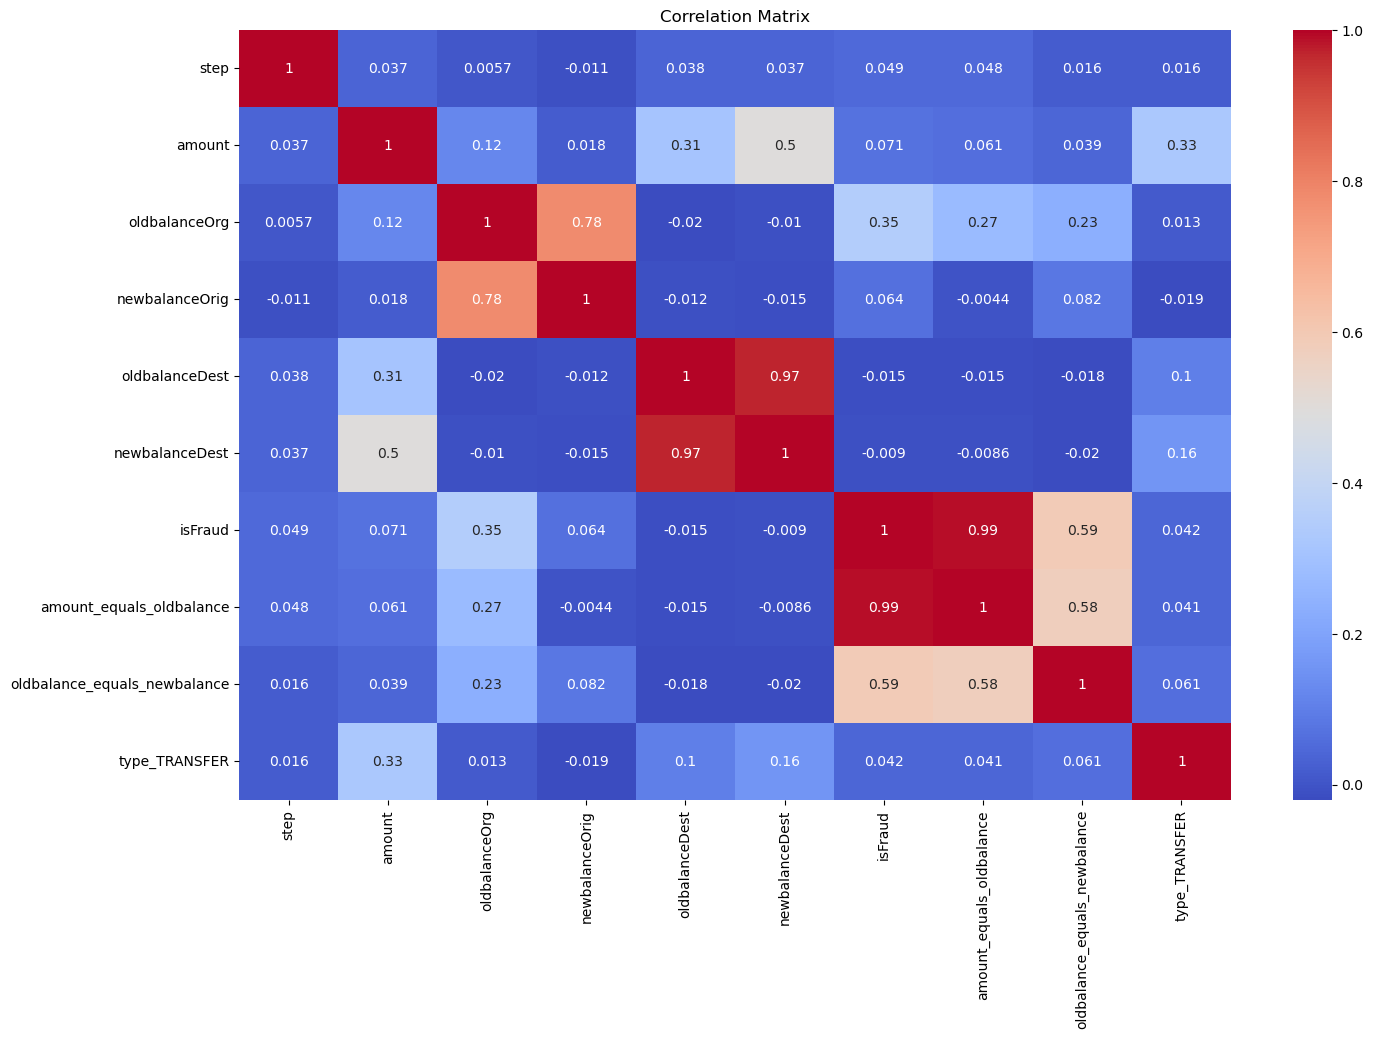

In [18]:
# Correlation matrix
correlation_matrix = df_complete.corr(numeric_only=True)

# Heatmap of the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## Next steps

The dataframe of interest is fully processed and ready for modeling. Ready for saving

Things to note:
- I considered creating two seperate dataframes for modeling; one for cash-out transactions and another for transfer transactions. I wanted to do this because I wanted the columns that I engineered to only be associated with the types of transactions. I figured that by one hot encoding, this problem would be resolved. However, perhaps I potentially added noise.

- I'll test and view the results, and if the results seem off, I'll do the above

If reattempting:

1. Create seperate dataframes
2. Use same code for feature engineering
3. Include this code to scale each df

- columns_to_scale = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
standard_scaler = StandardScaler()

- cash_out_scaled = cash_out.copy()  # Create a copy to keep the original DataFrame intact
cash_out_scaled[columns_to_scale] = standard_scaler.fit_transform(cash_out[columns_to_scale])

- transfer_scaled = transfer.copy()  # Create a copy to keep the original DataFrame intact
transfer_scaled[columns_to_scale] = standard_scaler.fit_transform(transfer[columns_to_scale])

4. Ready for modeling, no need to do get dummies, as each df is its own category

In [22]:
# save data for later modeling
df_complete.to_csv("../data/processed/PS_20174392719_1491204439457_log_processed.csv", index=False)

In [ ]:
# # Batching


# import pandas as pd

# chunk_size = 50000  # Adjust based on your system's memory
# chunks = []

# for chunk in pd.read_csv('large_dataset.csv', chunksize=chunk_size):
#     # Perform EDA on the chunk
#     # For example, you could aggregate data from each chunk to reduce its size
#     processed_chunk = chunk.groupby('some_column').aggregate('mean')
#     chunks.append(processed_chunk)

# # Combine processed chunks if needed
# final_result = pd.concat(chunks)